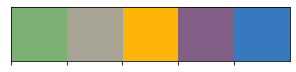

In [1]:
#!/usr/bin/env python
# coding: utf-8

# Sarahfong


# 2019-06-03 - created and run on common variants AF > 0.01

##### updates #####

# 2019-06-10
    # AF calculation was not correct. 0.01<= AF <0.5 is the maf, and 0.5=<AF=<1 is the AF
    # SNPs recalculated as maf.
    # Instead of intersecting only common variants (AF >= 0.01), intersect all variants.
    # maf rounded to 7th decimal




# Analyze the genomic shuffle of FANTOM eRNA enhancers for breaks v. actual transcribed enhancers.


import glob
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
import numpy as np
import os, sys
from scipy import stats
import seaborn as sns
import subprocess

colors = ["faded green", "greyish",  "amber", "dusty purple", "windows blue",]
palette = sns.xkcd_palette(colors)
sns.palplot(palette)

RE = "/dors/capra_lab/projects/enhancer_ages/1000g/results/"

#Fantom
PATH = "/dors/capra_lab/projects/enhancer_ages/fantom/data/architecture_coordinates/"
fs = [
    f"{PATH}all_fantom/no-exon_FANTOM_complexcore_age_breaks.bed",
    f"{PATH}all_fantom/no-exon_FANTOM_complexenh_age_breaks.bed",
    f"{PATH}all_fantom/no-exon_FANTOM_derived_age_breaks.bed",
    f"{PATH}all_fantom/no-exon_FANTOM_simple_age_breaks.bed"]

#1000g
THOU_PATH = "/dors/capra_lab/projects/enhancer_ages/1000g/data/maf/"
common_var_beds = glob.glob(f"{THOU_PATH}trimmed.chr*.phase3_shapeit2_mvncall_integrated_v5a.maf.bed")

In [2]:
#%% subtract exons function


def load_syn_gen_bkgd(build):

    F = f"/dors/capra_lab/projects/enhancer_ages/{build}_syn_taxon.bed"
    syngenbkgd = pd.read_csv(F, sep='\t')
    syngenbkgd[["mrca", "mrca_2"]] = syngenbkgd[["mrca", "mrca_2"]].round(3)

    return syngenbkgd


def intersect_1000G(file_list, common_var_beds, thou_path):

    F_filter = ["complexenh", "simple"]
    outfile_list = []
    for f in file_list:

        if "shuffle" in f:
            sid = (f.split("/")[-1]).split(".")[0] # different str.split strategy for shuffles.
            done = glob.glob("%sshuffle_FANTOM_*_x_trimmed.bed" % (thou_path))
            len_done = len(done) # Check that you haven't done this already.

        else:
            sid = ((f.split("/")[-1]).split("_")[2])
            done = glob.glob("%sFANTOM_*_x_trimmed.bed" % (thou_path))
            len_done = len(done)# Check that you haven't done this already.



        if sid in F_filter and len_done >4:
            for b in common_var_beds:
                chr_num = (b.split("/")[-1]).split(".")[1]
                outfile = "%s%s_x_%s_trimmed.bed" % (thou_path, chr_num, sid)
                bed_cmd = "bedtools intersect -a %s -b %s  -wa -wb> %s" % (fantom, b, outfile)

                subprocess.call(bed_cmd, shell = True)
                outfile_list.append(outfile)
        else:
            outfile_list = done
    return outfile_list


def get_dataframes(file_list, syngenbkgd):

    files_dict= {}
    for file in file_list:
        if "complexenh" not in file:
            df = pd.read_csv(file, sep = '\t', header = None)


            df.columns = ["chr_syn", "start_syn", "end_syn", "mrca", "enh_id",
            "chr_snp", "pos-1", "pos", "qual", "AF", "gwas_id", "overlap"]

            # formatting
            if "shuffle" in file:
                sid = "_".join((file.split('/')[-1]).split("_")[0:3])
                df["code"] = sid.split("_")[2]
                df["dataset"] = "shuffle"
            else:
                sid = "_".join((file.split('/')[-1]).split("_")[0:2])
                df["code"] = sid.split("_")[1]
                df["dataset"] = "FANTOM"

            print(sid)
            files_dict[sid] = df # add to dictionary


    df = pd.concat(files_dict.values()) # concat enh dictionaries

    df["mrca"] = df["mrca"].round(3)

    df = pd.merge(df,syngenbkgd, how = "left", on = "mrca") # taxon names

    df["AF"] = df["AF"].astype(float)

    df["syn_id"] = df.chr_syn + ":" + df.start_syn.map(str) + "-" + df.end_syn.map(str)
    # create rank system for simple, core and derived segments
    df["core_remodeling_2"] = 0
    df.loc[df["code"] == "complexcore", "core_remodeling_2"] = 1
    df.loc[df["code"] == "derived", "core_remodeling_2"] = 2

    df["core_remodeling"] = 1
    df.loc[df["code"] == "simple", "core_remodeling"] = 0
    df["counts"] = 1


    return df


def check_for_incomplete_arch(df):
    # sometimes we have derived regions in here w/o cores
    remove_incomplete_arch = []
    check_core_der = cdf.loc[(cdf.code == "derived")]
    for enh_id in check_core_der.enh_id.unique():
        test = check_core_der.loc[check_core_der.enh_id == enh_id]
        ids = check_core_der["code"].unique()
        if len(ids)<2:
            remove_incomplete_arch.append(enh_id)

    print("removing incomplete architectures", len(remove_incomplete_arch))
    # remove any incomplete architectures
    df = df.loc[~df.enh_id.isin(remove_incomplete_arch)]

    return df
def get_core_age(df):
    core = df.groupby("enh_id")["mrca_2"].max().reset_index()
    core.columns = ["enh_id", 'core_mrca_2']
    df = pd.merge(df, core, how = "left")

    return df
def get_singletons(df):

    sdf = df.loc[(df["AF"] < 0.0004) & (df["overlap"] == 1)] # get only singletons among all variants that overlap enhancers

    sdf_freq = sdf.groupby(["code", "dataset"])["overlap"].sum().reset_index() # sum the overlaps
    sdf_freq.columns = ["code", "dataset", "singleton_count"]

    total_freq = df.groupby(["code"])["overlap"].sum().reset_index() # sum total overlaps
    total_freq.columns = ["code", "df_count"]

    freq_ = pd.merge(sdf_freq, total_freq, how = "left", on = "code")

    freq_["freq"] = freq_["singleton_count"].divide(freq_["df_count"])

    return freq_


def singleton_foldchange(freq, shuf_freq):
    shuf_freq.columns = ["code", "shuf_dataset", "shuf_singleton_count", "shuf_df_count", "shuf_freq"]
    fold_change = pd.merge(freq, shuf_freq, how = "left", on = "code")



    fold_change["foldchange"] = fold_change.freq.divide(fold_change.shuf_freq)

    return fold_change


def plot_singletons(plot, singletonfc):

    plot_order =[ "simple", "complexenh", "complexcore" ,"derived"]

    f, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 6))

    x, y = "code", "freq"
    hue = "dataset"
    data = plot

    sns.barplot(
    x = x,
    y =y,
    data = data,
    hue = hue,
    order = plot_order,
    ax = ax1)

    ax1.set(ylabel = "% of arch dataset",
    title = "% Singleton in archicture dataset")

    ax1.set_xticklabels(ax1.get_xticklabels(), rotation =90)
    ax1.legend(bbox_to_anchor=(1.2, 1.0))

    # plot foldchange
    y = "foldchange",
    data = singletonfc

    sns.pointplot(
        x = x,
        y = y,
        data = data,
        order = plot_order,
        ax = ax2,)
        #join = False)
    ax2.set(ylabel = "fold change arch/bkgd",
    title = "fold change\nFANTOM v. shuffle singleton")

    ax2.set_xticklabels(ax2.get_xticklabels(), rotation =90)

    plt.tight_layout()
    outplot = "%ssingletons_FANTOM_arch.pdf" % RE
    plt.savefig(outplot, bbox_inches = "tight")


def make_empty_dict(df, groupby_cols):
    # for when i need an empty dictionary with a complete set of architectures and values
    emptydf_dict = {}
    val = 0 # unique identifier
    if len(groupby_cols) == 2:
        for mrca_2 in df[groupby_cols[0]].unique():
            for arch in df[groupby_cols[1]].unique():
                emptydf = pd.DataFrame({ groupby_cols[0]:[mrca_2], groupby_cols[1]:[arch],})
                emptydf_dict[val] = emptydf
                val+=1

    elif len(groupby_cols) == 1:
        for mrca_2 in df[groupby_cols[0]].unique():
            emptydf = pd.DataFrame({ groupby_cols[0]:[mrca_2]})
            emptydf_dict[val] = emptydf
            val+=1
    empty = pd.concat(emptydf_dict.values())

    return empty


def get_counts(df, groupby_cols, groupby_val):

    counts = df.groupby(groupby_cols)[groupby_val].sum().reset_index()


    empty = make_empty_dict(df, groupby_cols) # make an empty df to fill architectures w/ no counts
    counts = pd.merge(empty, counts, how = "left").fillna(0)

    # change count data to int
    counts[groupby_val] = counts[groupby_val].astype(int)

    # sort and reset the index. Seaborn plots by index value.
    counts = counts.sort_values(by = groupby_cols).reset_index()

    # drop the index column.
    counts = counts.drop(["index"], axis = 1)

    return counts


def plot_annotate_counts(splot, counts_df, groupby_val, height_adjust):

    # annotate plot with counts
    for n, p in enumerate(splot.patches):

        value = counts_df.iloc[n][groupby_val].astype(int)
        #print(n, p, value)
        if height_adjust == 0:
            height_adjust = (p.get_height()-0.03)


        splot.annotate(value,
                       (p.get_x() + p.get_width() / 2.,height_adjust),
                       ha = 'center', va = 'baseline',
                       size=15,
                       rotation = 90,
                       color = "k",
                       xytext = (0, 1),
                       textcoords = 'offset points'
                       )

def plot_figure6(x, y, df, fig_id, re, trim_len, frac, dataset):
    # sns colors
    arch_colors = [ "amber", "dusty purple", "windows blue","greyish"]
    arch_palette = sns.xkcd_palette(arch_colors)

    pal = [ "amber", "faded green"]
    palette = sns.xkcd_palette(pal)

    # for ranking and stratifying by age and architecture, set x1 for counts
    if x == 'arch':
        x1 = "core_remodeling"
        pal = palette
        order_labs = ["simple", "complex"]
        order = [0,1]
    elif x == "code":
        x1 = "core_remodeling_2"
        pal = arch_palette
        order_labs = ["simple", "core", "derived"]
        order = [0,1,2]

    if y == "snp_den":
        ylab = y
    elif y == "AF":
        ylab = "maf"
    xlab = ['Homo', 'Prim', 'Euar', 'Bore', 'Euth', 'Ther', 'Mam',
    'Amni', 'Tetr', 'Vert']

    title = dataset

    # set up plot
    sns.set("poster")
    fig = plt.figure(figsize = (12, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])
    ax = plt.subplot(gs[0])

    # plot the first panel
    data = df

    splot = sns.boxplot(x1, y, data = data,
                        showfliers = False,
                        palette = pal, order = order,
                        ax = ax)

    #ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.set_xticklabels(order_labs, rotation = 90)

    # get counts for annotation
    groupby_cols, groupby_val = [x1], "counts"
    countdf = get_counts(df, groupby_cols, groupby_val)
    height_adjust = 0.001
    plot_annotate_counts(splot, countdf, groupby_val, height_adjust)

    # plot the second panel
    ax2 = plt.subplot(gs[1])

    x = "core_mrca_2"
    data = df.sort_values(by = "core_mrca_2")
    hue = x1

    # plot mrca-stratified barplot

    mplot = sns.boxplot(x, y, data = data,
                        showfliers = False,
                        hue = hue,
                        palette = pal,
                        ax = ax2)

    # add counts and annotate barplot
    groupby_cols, groupby_val = [x1, "core_mrca_2"], "counts"
    countdf = get_counts(df, groupby_cols, groupby_val)
    plot_annotate_counts(mplot, countdf, groupby_val, height_adjust)

    # plot x labels
    ax2.set_xticklabels(xlab, rotation = 90)
    ax2.set(xlabel = "", ylabel = "", title = title)

    ax2.legend().remove()

    #ax2.yaxis.set_major_locator(MultipleLocator(0.1))

    ax2lim = ax2.get_ylim()
    # set first plot lim based on second plot lim
    ax.set(xlabel = "", ylabel = ylab, ylim = ax2lim)

    outf = f"{re}fig{fig_id}_1000G_{trim_len}_noexon_{dataset}_{frac}_mrcas.pdf"

    plt.savefig(outf, bbox_inches = "tight")


    # do stats
    simple = df.loc[df.code.str.contains('simple'), y]
    complexcore = df.loc[df.code.str.contains('complexcore'), y]
    derived = df.loc[df.code.str.contains('derived'), y]
    k, kp = stats.kruskal(simple,complexcore,derived)
    m, mp = stats.mannwhitneyu(complexcore,  derived)

    stat_df = pd.DataFrame({
    "test": ["krusal-wallis", "MWU"],
    "comparison":["simple v.complexcore v. complexderived", "complexcore v. derived"],
    "stat":[k,m],
    "p-value":[kp, mp]
    })
    medians = df.groupby("code")[y].median().reset_index()
    medians.columns = ["code", f"median_{y}"]
    means =  df.groupby("code")[y].mean().reset_index()
    means.columns = ["code", f"mean_{y}"]

    out_stat_df = f"{RE}1000G_FANTOM_arch_nosingletons_{y}_median_mean.tsv"
    metrics = pd.concat([medians, means])
    metrics.to_csv(out_stat_df, sep = '\t', index = False) # write the stats results

    out_stat_df = f"{RE}1000G_FANTOM_arch_nosingletons_{y}_mwu.tsv"
    stat_df.to_csv(out_stat_df, sep = '\t', index = False) # write the stats results
    return stat_df


def get_metrics(cdf, RE, x):

    #counts
    counts = cdf.groupby("code")[x].count()
    counts["metric"] = "counts"

    #medians
    medians = cdf.groupby("code")[x].median()
    medians["metric"] = "median"

    #means
    means = cdf.groupby("code")[x].mean()
    means["metric"] = "mean"

    # file to write dataframe
    outstat_file = f"{RE}1000g_no_singleton_metric_{x}.tsv"
    # concat dataframes
    outstats = pd.concat([counts, medians, means])

    # write dataframe
    outstats.to_csv(outstat_file, sep = '\t', index = False)


def get_snp_density(cdf):

    test = cdf.groupby(["enh_id", "syn_id", "chr_syn", "start_syn", "end_syn",
     "code", "core_mrca_2", "core_remodeling_2"])["overlap"].count().reset_index()

    # in this dataframe, the start and end coordinates correspond to the boundaries of syntenic coordinates
    # there may be >1 derived row for an enhancer (e.g. "chr10:101539519-101539906")
    test["seg_len"] = test.end_syn - test.start_syn

    # sum seg_lens and overlapping SNP counts for enhancers that have more than 1 derived entry.
    snp_den = test.groupby(["enh_id", "syn_id", "code"])[["overlap", "seg_len"]].sum().reset_index()

    snp_den["snp_den"] = snp_den.overlap.divide(snp_den.seg_len) # calculate the SNP density

    return snp_den

FANTOM_derived
FANTOM_complexcore
FANTOM_simple


/home/fongsl/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/fongsl/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/fongsl/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/fong

code
complexcore    0.021207
derived        0.026313
simple         0.019259
Name: snp_den, dtype: float64

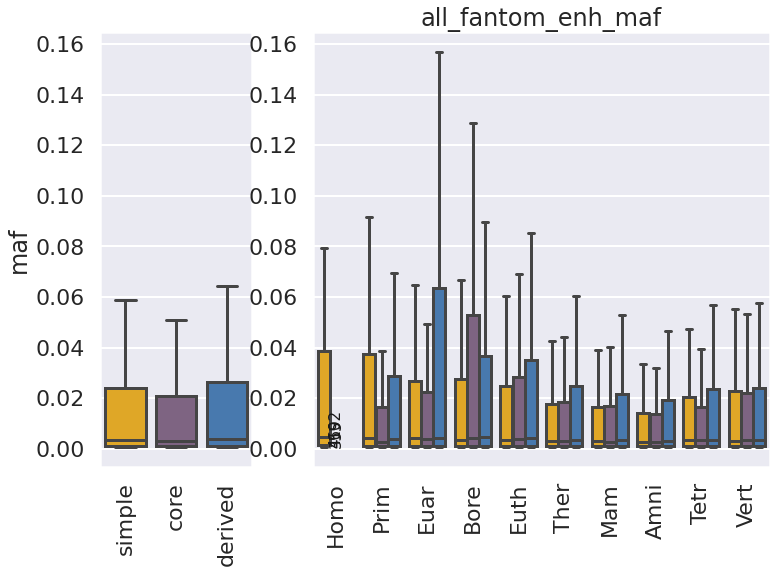

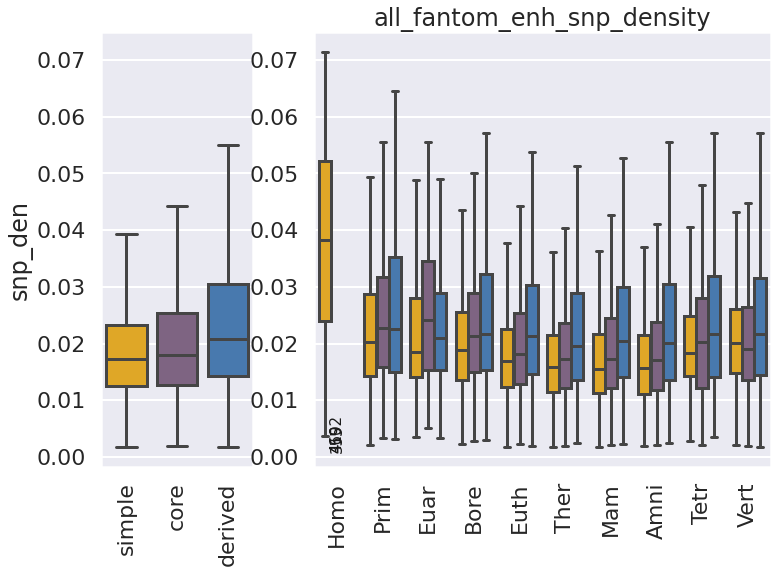

In [3]:
#%% # Fantom arch intersection w/ 1000G

outfiles = intersect_1000G(fs, common_var_beds, THOU_PATH)


#%% # shuffle arch intersection w/ 1000G
"""
SHUFPATH = "/dors/capra_lab/projects/enhancer_ages/fantom/data/architecture_coordinates/"
shuff_samples = f"{SHUFPATH}shuffle_FANTOM*.bed"
shuff_samples_list = glob.glob(shuff_samples)
shuff_samples_list
shuff_outfiles = intersect_1000G(shuff_samples_list, common_var_beds, THOU_PATH)
shuff_outfiles
"""
#%% # Analysis
BUILD = "hg19"
syngenbkgd = load_syn_gen_bkgd(BUILD)

df = get_dataframes(outfiles, syngenbkgd)

#%%
"""
shuf = get_dataframes(shuff_outfiles, syngenbkgd)


#%% # Singletons only
#SINGLETONS: 1 mutation/2504 individuals = 0.000399 mutations / individuals.
# get dataframes for singletons
freq = get_singletons(df)

shuf_freq = get_singletons(shuf)


#%% prepare to plot singletons
plot = pd.concat([shuf_freq, freq])

# get fold change
singletonfc = singleton_foldchange(freq, shuf_freq)

# plot singletons
plot_singletons(plot, singletonfc)
"""
#%% # Exclude singletons

cdf = df.loc[df["AF"] > 0.0004] # FILTER remove singletons + enhancers w/ no variant overlap
cdf = get_core_age(cdf)
remove_ids = cdf.loc[(cdf.code == "derived") & (cdf.core_mrca_2 == 0)]["enh_id"].unique()
cdf = cdf.loc[~cdf.enh_id.isin(remove_ids)]


get_metrics(cdf, RE, "AF")
x, y = "code", "AF"

fig_id = "6B"
re = RE
trim_len = "raw"
frac = "all"
dataset = "all_fantom_enh_maf"
sd = plot_figure6(x, y, cdf, fig_id, re, trim_len, frac, dataset)


cdf.groupby('code')["AF"].mean()
# # SNP Density x architecture

# In[39]:

snp_den = get_snp_density(cdf)

# add back the core age and remodeling annotations for plotting.
snp_den  = pd.merge(snp_den, cdf[["enh_id", "syn_id", "core_remodeling_2", "core_mrca_2"]], how = "left")
snp_den["counts"] = 1 # add count column for plotting .

x, y = "code", "snp_den"
fig_id = "6C"
re = RE
trim_len = "raw"
frac = "all"
dataset = "all_fantom_enh_snp_density"
sd = plot_figure6(x, y, snp_den, fig_id, re, trim_len, frac, dataset)

snp_den.groupby('code')["snp_den"].mean()

In [4]:
snp_den.groupby('code')["snp_den"].median()

code
complexcore    0.018018
derived        0.020725
simple         0.017241
Name: snp_den, dtype: float64